The dataset has 1 CSV file with 10 columns -

realtor-data.csv (2,226,382 entries)  
brokered by (categorically encoded agency/broker)  
status (Housing status - a. ready for sale or b. ready to build)  
price (Housing price, it is either the current listing price or recently sold * price if the house is sold recently)  
bed (# of beds)  
bath (# of bathrooms)  
acre_lot (Property / Land size in acres)      
street (categorically encoded street address)  
city (city name)  
state (state name)  
zip_code (postal code of the area)  
house_size (house area/size/living space in square feet)  
prev_sold_date (Previously sold date)  

Note:

brokered by and street addresses were categorically encoded due to privacy policy
acre_lot means the total land area, and house_size denotes the living space/building area

In [1]:
!pip install us

In [2]:
import plotly.graph_objects as go
import plotly.express as px
import json

In [3]:
!pip install folium

import folium
import pandas as pd
import numpy as np
from folium.plugins import MarkerCluster

In [4]:
import numpy as np
import pandas as pd
import seaborn as sns
import folium
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
import numpy as np
import us
from sklearn.model_selection import StratifiedShuffleSplit, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer, OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer

In [5]:
from google.colab import drive
drive.mount('/content/drive')
file_name = 'drive/MyDrive/realtor-data.csv'

df = pd.read_csv(file_name)

Mounted at /content/drive


In [6]:
df.head()

,brokered_by,status,price,bed,bath,acre_lot,street,city,state,zip_code,house_size,prev_sold_date
0,103378.0,for_sale,105000.0,3.0,2.0,0.12,1962661.0,Adjuntas,Puerto Rico,601.0,920.0,NaN
1,52707.0,for_sale,80000.0,4.0,2.0,0.08,1902874.0,Adjuntas,Puerto Rico,601.0,1527.0,NaN
2,103379.0,for_sale,67000.0,2.0,1.0,0.15,1404990.0,Juana Diaz,Puerto Rico,795.0,748.0,NaN
3,31239.0,for_sale,145000.0,4.0,2.0,0.10,1947675.0,Ponce,Puerto Rico,731.0,1800.0,NaN
4,34632.0,for_sale,65000.0,6.0,2.0,0.05,331151.0,Mayaguez,Puerto Rico,680.0,NaN,NaN


In [7]:
df.shape

(2226382, 12)

In [8]:
df.columns

Index(['brokered_by', 'status', 'price', 'bed', 'bath', 'acre_lot', 'street',
       'city', 'state', 'zip_code', 'house_size', 'prev_sold_date'],
      dtype='object')

In [9]:
df.describe()

,brokered_by,price,bed,bath,acre_lot,street,zip_code,house_size
count,2.221849e+06,2.224841e+06,1.745065e+06,1.714611e+06,1.900793e+06,2.215516e+06,2.226083e+06,1.657898e+06
mean,5.293989e+04,5.241955e+05,3.275841e+00,2.496440e+00,1.522303e+01,1.012325e+06,5.218668e+04,2.714471e+03
std,3.064275e+04,2.138893e+06,1.567274e+00,1.652573e+00,7.628238e+02,5.837635e+05,2.895408e+04,8.081635e+05
min,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4.000000e+00
25%,2.386100e+04,1.650000e+05,3.000000e+00,2.000000e+00,1.500000e-01,5.063128e+05,2.961700e+04,1.300000e+03
50%,5.288400e+04,3.250000e+05,3.000000e+00,2.000000e+00,2.600000e-01,1.012766e+06,4.838200e+04,1.760000e+03
75%,7.918300e+04,5.500000e+05,4.000000e+00,3.000000e+00,9.800000e-01,1.521173e+06,7.807000e+04,2.413000e+03
max,1.101420e+05,2.147484e+09,4.730000e+02,8.300000e+02,1.000000e+05,2.001357e+06,9.999900e+04,1.040400e+09


In [43]:
df.isnull().sum()

brokered_by         4533
status                 0
price               1541
bed               481317
bath              511771
acre_lot          325589
street             10866
city                1407
state                  8
zip_code             299
house_size        568484
prev_sold_date    734297
dtype: int64

In [35]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2226382 entries, 0 to 2226381
Data columns (total 12 columns):
 #   Column          Dtype  
---  ------          -----  
 0   brokered_by     float64
 1   status          object 
 2   price           float64
 3   bed             float64
 4   bath            float64
 5   acre_lot        float64
 6   street          float64
 7   city            object 
 8   state           object 
 9   zip_code        float64
 10  house_size      float64
 11  prev_sold_date  object 
dtypes: float64(8), object(4)
memory usage: 203.8+ MB


In [36]:
#The true values show NaN values in that col
for feature in df.columns:
    print(df[feature].isna().value_counts("True"), "\n")

brokered_by
False    0.997964
True     0.002036
Name: proportion, dtype: float64 

status
False    1.0
Name: proportion, dtype: float64 

price
False    0.999308
True     0.000692
Name: proportion, dtype: float64 

bed
False    0.783812
True     0.216188
Name: proportion, dtype: float64 

bath
False    0.770133
True     0.229867
Name: proportion, dtype: float64 

acre_lot
False    0.853759
True     0.146241
Name: proportion, dtype: float64 

street
False    0.995119
True     0.004881
Name: proportion, dtype: float64 

city
False    0.999368
True     0.000632
Name: proportion, dtype: float64 

state
False    0.999996
True     0.000004
Name: proportion, dtype: float64 

zip_code
False    0.999866
True     0.000134
Name: proportion, dtype: float64 

house_size
False    0.74466
True     0.25534
Name: proportion, dtype: float64 

prev_sold_date
False    0.670184
True     0.329816
Name: proportion, dtype: float64 



Brokered_by and street are categorically encoded and we don't know how we will not use them further.

In [10]:
data = df.copy()

In [11]:
data.drop(columns=["brokered_by","street"], inplace=True)

In [39]:
# data.dropna(subset=[ "price", "acre_lot", "bath", "bed", "house_size", "prev_sold_date", "city", "state", "zip_code"], inplace=True)

Proportion of houses by state?

In [12]:
state_proportions = df['state'].value_counts() / len(df)

fig = px.bar(state_proportions.reset_index().sort_values(by='count', ascending=False), x='state', y='count'
             ,color = 'state' ,title='Proportion of Houses by State')
fig.update_layout(showlegend=False)
fig.show()

Which state is the most expensive?

In [13]:
data = data[data["zip_code"]>0]
data['ZIP']=data['zip_code'].map(str)
data['ZIP']=data["ZIP"].str.split(".").str[0]
zipcodes = data.copy()
zipcodes['ZIP']=zipcodes["ZIP"].str.split(".").str[0]

In [14]:
city = zipcodes[["city","ZIP"]].copy()
city.drop_duplicates('ZIP', inplace=True)
city

,city,ZIP
0,Adjuntas,601
2,Juana Diaz,795
3,Ponce,731
4,Mayaguez,680
5,San Sebastian,612
...,...,...
2221721,Spokane,99020
2221981,Waverly,99039
2223995,Rosalia,99176
2225634,Washtucna,99371


In [15]:
zipcodes.drop(columns=["status",'city', 'state',
       'zip_code', 'prev_sold_date'],inplace =True)
us_zipcodes = pd.read_csv("https://gist.githubusercontent.com/abatko/ee7b24db82a6f50cfce02afafa1dfd1e/raw/dd88ce02f2cb920e8ff6fa66052d9ab8a72ffb5a/US%2520Zip%2520Code%2520Geolocations%2520from%25202018%2520Government%2520Data", delimiter=',', dtype=str)

In [23]:
zipcodes_agg = pd.merge(zipcodes.groupby('ZIP').agg(np.mean), us_zipcodes, how='left', on='ZIP')
zipcodes_agg = pd.merge(zipcodes_agg, city, how='left', on='ZIP')
zipcodes_agg =zipcodes_agg.dropna(axis=0,how="any")
zipcodes_agg = zipcodes_agg.sample(n=500)
zipcodes_agg =zipcodes_agg.reset_index(drop=True)

<ipython-input-23-9cf18d18efc8>:1: FutureWarning:

The provided callable <function mean at 0x7a4450517d00> is currently using DataFrameGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.



In [21]:
zipcodes.head()

,price,bed,bath,acre_lot,house_size,ZIP
0,105000.0,3.0,2.0,0.12,920.0,601
1,80000.0,4.0,2.0,0.08,1527.0,601
2,67000.0,2.0,1.0,0.15,748.0,795
3,145000.0,4.0,2.0,0.10,1800.0,731
4,65000.0,6.0,2.0,0.05,NaN,680


In [24]:
zipcodes.columns

Index(['price', 'bed', 'bath', 'acre_lot', 'house_size', 'ZIP'], dtype='object')

In [25]:
map = folium.Map(location=[43, -100], zoom_start=4)

zipcodes_agg.reset_index(drop=True, inplace=True)


folium.Choropleth(
    geo_data="https://services.arcgis.com/P3ePLMYs2RVChkJx/arcgis/rest/services/USA_ZIP_Code_Areas_anaylsis/FeatureServer/0/query?outFields=*&where=1%3D1&f=geojson",
    data=zipcodes_agg,
    columns=['ZIP', 'price'],
    key_on='feature.properties.ZIP_CODE',
    fill_color='BuPu', fill_opacity=0.7, line_opacity=0.3,
    legend_name='PRICE'
).add_to(map)

marker_cluster = MarkerCluster().add_to(map)

for index, row in zipcodes_agg.iterrows():
    location = [row['LAT'], row['LNG']]
    tooltip = "Zipcode:{}<br> city: {}<br> Click for more".format(row["ZIP"], row['city'])
    popup = """<i>Mean sales price: </i> <br> <b>${}</b> <br>
               <i>mean total beds: </i> <b> <br>{}</b><br>
               <i>mean square feet: </i><b><br>{}</b><br>""".format(
               round(row['price'], 2), round(row['bed'], 2), round(row['house_size'], 2))
    folium.Marker(location, popup=popup, tooltip=tooltip).add_to(marker_cluster)

map

#continued on jupyter nb and updated and uploaded to colab since it keeps crashing


top 10 most expensive cities:-

In [46]:
city_prices = data.groupby('city')['price'].mean().reset_index()
tencit = city_prices.sort_values(by='price', ascending=False).head(10)
tencit

,city,price
19065,Wayne City,4.338663e+07
9694,Lassen Ave,3.778000e+07
8879,Kawaihae,2.500000e+07
19869,Woody Creek,2.098750e+07
16671,Snowville,1.958750e+07
8751,Jolly,1.791019e+07
6853,Golden Oak,1.638500e+07
16780,South Fork Lodgepole Rd,1.500000e+07
4099,Crows Landing,1.450000e+07
696,Atherton,1.373873e+07


Most expensive city?

In [39]:
state_prices = data.groupby('state')['price'].mean().reset_index()
ten = state_prices.sort_values(by='price', ascending=False).head(10)

In [40]:
ten

,state,price
12,Hawaii,1.240095e+06
4,California,1.019775e+06
34,New York,9.439075e+05
8,District of Columbia,8.828498e+05
47,Utah,8.814184e+05
5,Colorado,8.305324e+05
27,Montana,7.920827e+05
49,Virgin Islands,7.691129e+05
22,Massachusetts,7.248430e+05
11,Guam,7.138617e+05


<ipython-input-42-16bc085f5467>:2: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




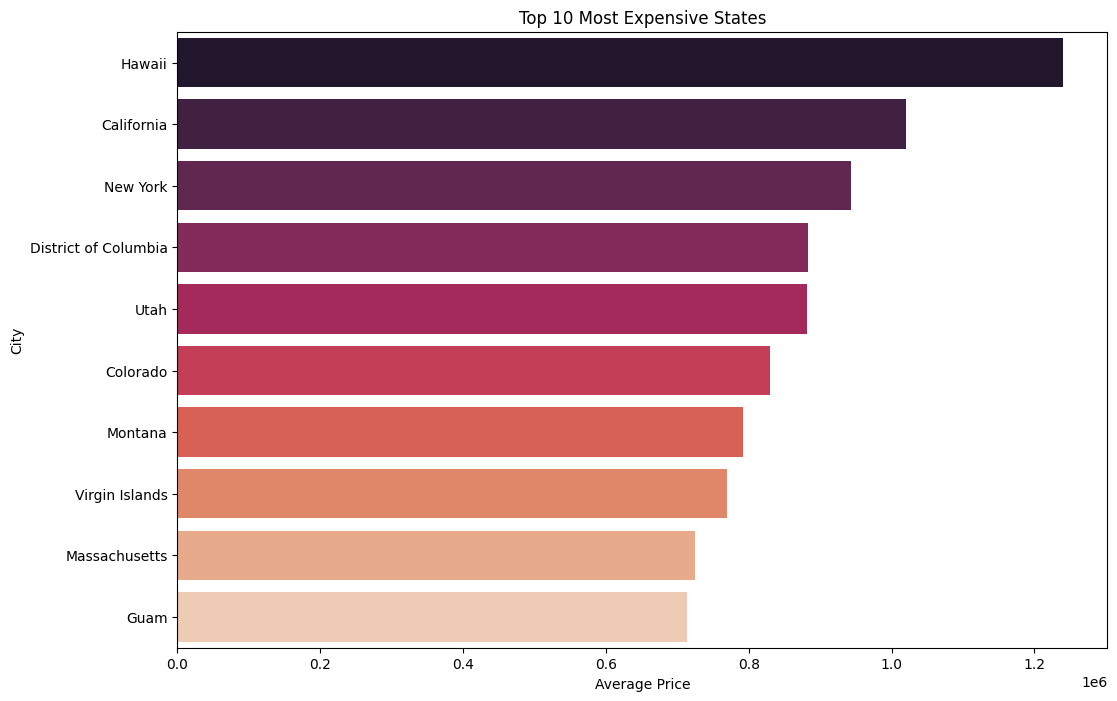

In [42]:
plt.figure(figsize=(12, 8))
sns.barplot(x='price', y='state', data=ten, palette='rocket')
plt.title('Top 10 Most Expensive States')
plt.xlabel('Average Price')
plt.ylabel('City')

# Show the plot
plt.show()